In [779]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [780]:
car_data = pd.read_csv('car_data.csv', header = 0)
car_data.drop(['User ID'], axis = 1, inplace = True)
car_data['Gender'].replace(['Male', 'Female'],[0, 1], inplace=True)
car_data.head()

,Gender,Age,AnnualSalary,Purchased
0,0,35,20000,0
1,0,40,43500,0
2,0,49,74000,0
3,0,40,107500,1
4,0,25,79000,0


In [781]:
y = car_data['Purchased']
car_data.drop(['Purchased'], axis = 1, inplace = True)

def absolute_maximum_scale(series):
    return series / series.abs().max()
    
for col in car_data.columns:
    car_data[col] = absolute_maximum_scale(car_data[col])

x = car_data.to_numpy()
y = y.to_numpy()


In [782]:
# Divide the data into train and test
n_train = car_data.shape[0] * 0.8
x_train = x[0: int(n_train), :].T
x_test = x[int(n_train):, :].T

y = y[:, np.newaxis]
y_train = y[0: int(n_train), :].T
y_test =  y[int(n_train):, :].T



In [783]:
def sigmoid(Z):
    """
    Compute the sigmoid of z
    """
    A = 1/(1+np.exp(-Z))
    
    return A

def relu(Z):
    """
    Implement the RELU function.
    """
    A = np.maximum(0,Z)

    return A


def sigmoid_backward(dA, Z):
    """
    Implement the backward propagation for SIGMOID.
    """
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    return dZ


def relu_backward(dA, Z):
    """
    Implement the backward propagation for RELU.
    """
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,}

    return params

def linear_activation_forward(A_prev, W, b, activation_type):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    """
    if activation_type == "sigmoid":
        Z = linear_forward(A_prev, W, b)
        A = sigmoid(Z)

    elif activation_type == "relu":
        Z = linear_forward(A_prev, W, b)
        A = relu(Z)

    cache = (A_prev, W, b, Z)

    return A, cache


def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.
    """
    
    Z = np.dot(W, A) + b
    
    return Z


def linear_activation_backward(dA, cache, activation_type):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    """
    A_prev, W, b, Z = cache
    
    if activation_type == "relu":
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
        
    elif activation_type == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, A_prev, W, b)
    
    return dA_prev, dW, db


def linear_backward(dZ, A_prev, W, b):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)
    """
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def get_cost(AL, Y):
    """
    Implement the cost function
    """
    m = Y.shape[1]
    cost = - (1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))

    cost = np.squeeze(cost)

    return cost


def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]

    return parameters

In [784]:
def model(X, Y, learning_rate = 0.1, num_iterations = 3000):
    np.random.seed(1)
    grads = {}
    costs = []
    accuracys = []

    n_x = x_train.shape[0]
    n_h = 2
    n_y = 1

    parameters = initialize_parameters(n_x, n_h, n_y)

    m = X.shape[1]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Gradient Descent
    for i in range(0, num_iterations):
        # Forward propagation:
        A1, cache1 = linear_activation_forward(X, W1, b1, 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, 'sigmoid')

        

        # Get cost
        cost = get_cost(A2, Y)

        # Backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation_type = 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation_type = 'relu')

        # Set grads
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # Print the cost every 100 training example
        if i % 100 == 0:
            accuracy = get_accuracy(A2, Y)
            print("Accuracy", accuracy * 100, '%')
        if i % 100 == 0:
            accuracys.append(accuracy)
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(accuracys))
    plt.ylabel('accuracy')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters




In [785]:
def get_accuracy(predictions, Y):
    predictions[predictions <= 0.5] = 0
    predictions[predictions > 0.5] = 1
    return np.sum(predictions == Y) / Y.size

Accuracy 51.625 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.62499999999999 %
Accuracy 59.875 %
Accuracy 72.0 %
Accuracy 80.625 %
Accuracy 81.875 %
Accuracy 82.375 %
Accuracy 83.25 %
Accuracy 83.0 %
Accuracy 83.125 %
Accuracy 83.5 %
Accuracy 83.75 %
Accuracy 83.875 %
Accuracy 84.0 %
Accuracy 84.0 %
Accuracy 83.75 %
Accuracy 83.875 %
Accuracy 83.75 %


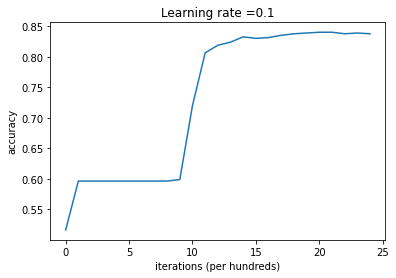

In [786]:
parameters = model(x_train, y_train, num_iterations=2500)

In [787]:
def predict(x, y, parameters):
    A1, cache1 = linear_activation_forward(x, parameters['W1'], parameters['b1'], 'relu')
    A2, cache2 = linear_activation_forward(A1, parameters['W2'], parameters['b2'], 'sigmoid')

    accuracy = get_accuracy(A2, y)
    return accuracy

In [788]:
predictions_train = predict(x_test, y_test, parameters)
print('Test Accuracy:', predictions_train * 100, '%')

Test Accuracy: 79.0 %
